# The life of a Numba kernel - from Python source to kernel launch

**Author:** Graham Markall ([@gmarkall](https://twitter.com/gmarkall))

This notebook gives an overview of the compiler and runtime pipeline that Numba uses to take Python source code, turn it into a CUDA kernel, and launch it. It pulls in a variety of Numba internals to illustrate how the different parts of the pipeline work.

## Overview

The Numba CUDA target (or CUDA Python, as it's sometimes referred to) has three components:

1. A NumPy-like array library backed by CUDA
2. A Python-to-PTX compiler that uses NVVM
3. A Python interface to the CUDA driver API

The first part of this notebook is about the Python-to-PTX compiler that uses NVVM, and this follows on to an overview of the Python interface to the CUDA driver API. We will follow through the process that starts with a Python function, and ends with the execution of a kernel on the GPU.

## A simple kernel

Throughout the notebook we'll use a simple L1 BLAS-like kernel for the example. Let's import Numba and NumPy, and define the kernel:

In [1]:
from numba import cuda
import numpy as np

In [2]:
@cuda.jit
def axpy(r, a, x, y): 
    i = cuda.grid(1)

    if i < len(r):
        r[i] = a * x[i] + y[i]

Now let's create some data:

In [3]:
N = 10000
a = 5.0 
x = np.arange(N).astype(np.int32)
y = np.random.randint(100, size=N).astype(np.int32)
r = np.zeros_like(x)

and launch the kernel using that data:

In [4]:
threads = 256 
blocks = (N // threads) + 1 
axpy[blocks, threads](r, a, x, y)

/home/gmarkall/numbadev/numba-cuda/numba_cuda/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 40 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/gmarkall/numbadev/numba-cuda/numba_cuda/numba/cuda/cudadrv/devicearray.py:887: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


A quick sanity check to make sure it's done as we expected:

In [5]:
assert(np.all(r == a * x + y))

## What just happened?

When we configured and launched the kernel, Numba jumped in and compiled the kernel, transferred data to the GPU, launched the kernel on the data, and transferred the result back. How did Numba compile and load the kernel to the GPU? The process is outlined in this flowchart:

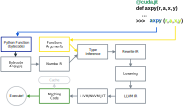

In [6]:
from IPython.core.display import SVG
SVG(filename='numba-pipeline.svg')

We'll follow through each of the steps in the notebook, mostly in code. Some of the following code uses various bits of Numba internals to get things done - this is to illustrate a little more clearly what Numba is doing, but be aware that in general it's not possible to drive Numba's pipeline from an external program.

## Bytecode compilation

Numba's input language is not Python source code / ASTs, but instead Python bytecode. The CPython interpreter compiles the source to Python bytecode - we can see what this looks like for our `axpy` function:

In [7]:
from dis import dis
dis(axpy.py_func)

  1           0 RESUME                   0

  3           2 LOAD_GLOBAL              0 (cuda)
             14 LOAD_METHOD              1 (grid)
             36 LOAD_CONST               1 (1)
             38 PRECALL                  1
             42 CALL                     1
             52 STORE_FAST               4 (i)

  5          54 LOAD_FAST                4 (i)
             56 LOAD_GLOBAL              5 (NULL + len)
             68 LOAD_FAST                0 (r)
             70 PRECALL                  1
             74 CALL                     1
             84 COMPARE_OP               0 (<)
             90 POP_JUMP_FORWARD_IF_FALSE    25 (to 142)

  6          92 LOAD_FAST                1 (a)
             94 LOAD_FAST                2 (x)
             96 LOAD_FAST                4 (i)
             98 BINARY_SUBSCR
            108 BINARY_OP                5 (*)
            112 LOAD_FAST                3 (y)
            114 LOAD_FAST                4 (i)
            116 BINARY

The CPython bytecode is a sequence of instructions for a simple stack machine. The line numbers corresponding to each sequence of instructions is given in the first column (3, 5, and 6). The next column is the offset of each instruction in the bytecode - e.g. at location 20 we have `POP_JUMP_IF_FALSE 46`, which branches to location 46. The next column is the opcode - all opcodes are listed in [this section of the Python dis module documentation](https://docs.python.org/3/library/dis.html#python-bytecode-instructions). The next column is an operand, whose meaning varies between the opcodes - for example the operand to `POP_JUMP_IF_FALSE` is the location to jump to, whereas the operand for the `COMPARE_OP` is the type of comparison to perform - in this case, `0` indicates `<` - note that many instructions also pop operands from the stack - for example, the `BINARY_SUBSCR` uses the three items loaded to the top of the stack by the `LOAD_FAST` instructions at locations 22, 24, and 26.

Further reading: 
* [Numba manual: Bytecode Analysis](http://numba.pydata.org/numba-doc/dev/developer/architecture.html#stage-1-analyze-bytecode) - provides a slightly larger bytecode example.
* [Stack Machines on Wikipedia](https://en.wikipedia.org/wiki/Stack_machine) - not the greatest introduction, but contains a lot of information.

## Bytecode Analysis

Numba's first step is to translate the Python Bytecode into Untyped Numba IR - this is a representation closer to the LLVM IR that Numba will eventually hand to NVVM. Its design provides

* An abstract machine with infinite registers
* A representation that type inference can be executed on
* Support for rewriting the IR - transformations that make it easier to implement Python semantics in a lower-level representation.

Numba does two forms of analysis on the Python bytecode, which it then uses to construct the Numba IR:

* Control Flow Analysis
* Data Flow Analysis

To construct these, we use Numba's *Bytecode Interpreter*:

In [8]:
from numba.core.bytecode import ByteCode, FunctionIdentity
from numba.core.interpreter import Interpreter

fi = FunctionIdentity.from_function(axpy.py_func)
interp = Interpreter(fi)
bc = ByteCode(fi)
ir = interp.interpret(bc)

Let's first examine the Control Flow Analysis:

In [9]:
interp.cfa.dump()

CFG adjacency lists:
{0: [94, 144], 94: [], 144: []}
CFG dominators:
{0: {0}, 94: {0, 94}, 144: {144, 0}}
CFG post-dominators:
{0: {0}, 94: {94}, 144: {144}}
CFG back edges: []
CFG loops:
{}
CFG node-to-loops:
{0: [], 94: [], 144: []}
CFG backbone:
{0}


CFA provides the control flow graph in terms of the basic blocks of the function - in this function there are three basic blocks, numbered 0, 24, and 48. The adjacency list gives the control flow between the basic blocks - the existence of an edge implies control can flow from the source block to the destination block.

Knowing which nodes dominate which other nodes is also useful for various analyses - a node A dominates the node B if all control flow paths to B must pass through A.

Post-dominators are a bit like the reverse of a dominator - a node C post-dominates a node D if all paths starting at D must pass through C to exit the graph.

The text-based representation contains lots of information but is not that easy to interpret - Numba also provides a visual rendering of the CFG to help with interpreting it:

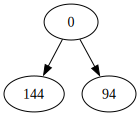

In [10]:
dg = interp.cfa.graph.render_dot()
dg

The graph in this case is rather simple - in block 0, we call `cuda.grid(1)` - if `i < len(r)`, control flow goes to block 24 then 48, otherwise it goes straight to 48 (the exit block).

The data flow analysis can also be viewed, but there is not such a convenient way to view it:

In [11]:
from pprint import pprint

for block, abi in interp.dfa.infos.items():
    print(f"Block {block}:\n")
    print("Instructions:")
    pprint(abi.insts)
    print()

Block 0:

Instructions:
((0, {}),
 (2, {}),
 (4, {'idx': 0, 'res': '$4load_global.0'}),
 (6, {}),
 (8, {}),
 (10, {}),
 (12, {}),
 (14, {}),
 (16, {'item': '$4load_global.0', 'res': '$16load_method.2'}),
 (18, {}),
 (20, {}),
 (22, {}),
 (24, {}),
 (26, {}),
 (28, {}),
 (30, {}),
 (32, {}),
 (34, {}),
 (36, {}),
 (38, {'res': '$const38.3'}),
 (40, {}),
 (42, {}),
 (44,
  {'args': ['$const38.3'],
   'func': '$16load_method.2',
   'kw_names': None,
   'res': '$44call.4'}),
 (46, {}),
 (48, {}),
 (50, {}),
 (52, {}),
 (54, {'value': '$44call.4'}),
 (56, {'res': '$i56.5'}),
 (58, {'idx': 2, 'res': '$58load_global.6'}),
 (60, {}),
 (62, {}),
 (64, {}),
 (66, {}),
 (68, {}),
 (70, {'res': '$r70.8'}),
 (72, {}),
 (74, {}),
 (76,
  {'args': ['$r70.8'],
   'func': '$58load_global.6',
   'kw_names': None,
   'res': '$76call.9'}),
 (78, {}),
 (80, {}),
 (82, {}),
 (84, {}),
 (86, {'lhs': '$i56.5', 'res': '$86compare_op.10', 'rhs': '$76call.9'}),
 (88, {}),
 (90, {}),
 (92, {'pred': '$86compare_op

## The Numba IR

We can view the Numba IR too:

In [12]:
ir.dump()

label 0:
    r = arg(0, name=r)                       ['r']
    a = arg(1, name=a)                       ['a']
    x = arg(2, name=x)                       ['x']
    y = arg(3, name=y)                       ['y']
    $4load_global.0 = global(cuda: <module 'numba.cuda' from '/home/gmarkall/numbadev/numba-cuda/numba_cuda/numba/cuda/__init__.py'>) ['$4load_global.0']
    $16load_method.2 = getattr(value=$4load_global.0, attr=grid) ['$16load_method.2', '$4load_global.0']
    $const38.3 = const(int, 1)               ['$const38.3']
    i = call $16load_method.2($const38.3, func=$16load_method.2, args=[Var($const38.3, 2721660990.py:3)], kws=(), vararg=None, varkwarg=None, target=None) ['$16load_method.2', '$const38.3', 'i']
    $58load_global.6 = global(len: <built-in function len>) ['$58load_global.6']
    $76call.9 = call $58load_global.6(r, func=$58load_global.6, args=[Var(r, 2721660990.py:1)], kws=(), vararg=None, varkwarg=None, target=None) ['$58load_global.6', '$76call.9', 'r']
    $86c

Examining the IR shows some correspondences between it and:

* The Python bytecode - we can see some similar semantics, for example the loading of globals and methods, and the calling of methods
* The names of the variables in the IR and the names in the Data Flow Analysis
* The control flow analysis - the structure of control flow of the Numba IR matches that in the bytecode, and produced by the CFA.

However, it is also a little different from the previous items:

* The Numba IR abstract machine is not a stack machine, but instead has an infinite number of variables (`$2load_global0`, etc).
* It doesn't explicitly hold the results of analysis, like the dominator and post-dominator analysis.

We can also view the Numba IR as a graph:

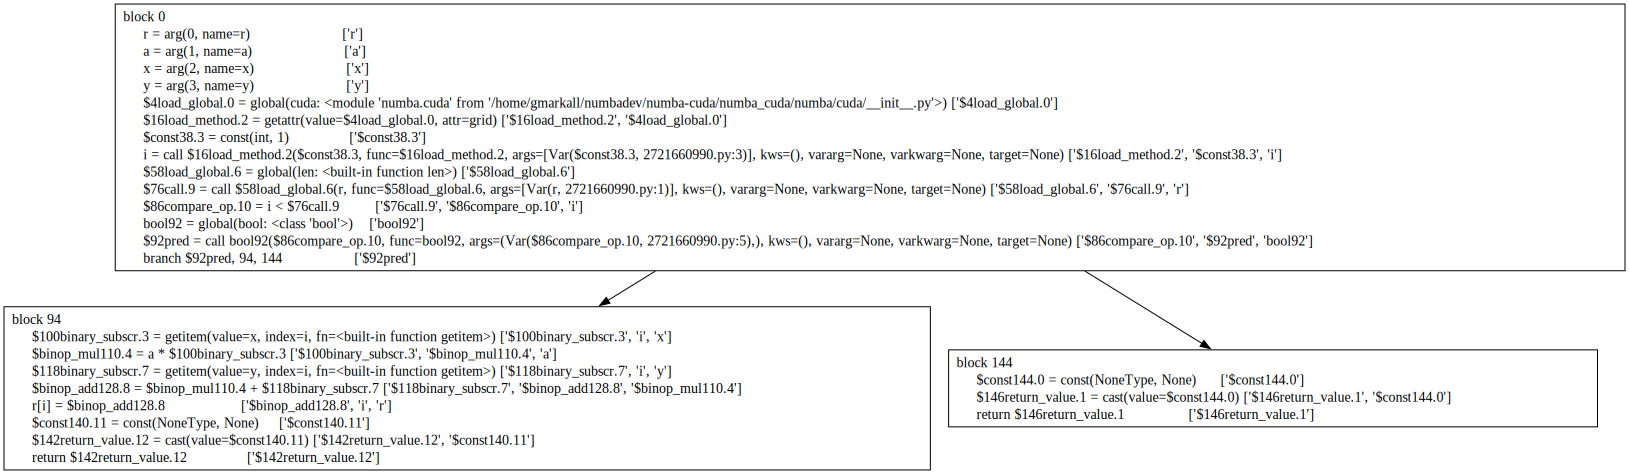

In [13]:
ir_dg = ir.render_dot()
ir_dg

## Rewrite passes

Some rewrites on the untyped IR occur at this point - e.g.

* Some constant propagation, e.g. where one side of a binary operation has a constant value
* Rewrite getitems where the index is known to be a constant
* Rewrite raise expressions with constant arguments so they can be used in nopython mode.

There is no easy way to look at these in the notebook, but most of them can be found in the `numba.core.rewrites` module, decorated with `@register_rewrite('before-inference')`.

## Type inference

Next is type inference. This starts with the types of the arguments and propagates type information through the function until everything has been typed. It uses:

* Internally stored mappings of input types to output types - e.g. "an add of a float32 and a float64 will have a return type of float64"
* The data flow graph

When there are two incoming types for a variable, e.g. when two different values can be assigned to it because of branching, Numba constructs a set of possible types for the variable, and attempts to "unify" them - that is, choose a type that all of the types in the set can be safely coerced to.

For example:

```python
def select(a, b, threshold, value):
    if threshold < value:
        r = a   # r: float32
    else:
        r = b   # r: int32
    return r    # r: {float32, int32} unifies to float64

a = np.float32(1)
b = np.int32(2)
select(a, b, 10, 11) # Call with (float32, int32, int64, int64)
```

In the above example `r` is typed as `float32` in the taken branch, and `int32` in the not-taken branch. On the line with the return, the control flow from the if-else re-joins, so the types of `r` from both sides of it are used to construct the set of types. Since the set of types contains different types (`int32` and `float32`), Numba uses a built-in rule for unification - in this case, to ensure the best representation of values from all branches, it chooses `float64`.

Further reading: [Numba Enhancement Proposal 1: Changes in Integer Typing](http://numba.pydata.org/numba-doc/latest/proposals/integer-typing.html) explains some of the rationale behind some of the decisions made by Numba's type system.

### Inspecting the result of type inference

We can use the `inspect_types()` function of a jitted kernel to see Numba's typing of all values in the function:

In [14]:
axpy.inspect_types()

_ZN6cudapy8__main__4axpyB2v1B96cw51cXTLSUwv1sCUt9Ww0FGw1NRRQPKiLTj0gIGIFp_2b2oLQFEYYkHSQB1OQAk0Bynm21OizQ1K0UoIGvDpQE8oxrNQE_3dE5ArrayIiLi1E1C7mutable7alignedEd5ArrayIiLi1E1C7mutable7alignedE5ArrayIiLi1E1C7mutable7alignedE (Array(int32, 1, 'C', False, aligned=True), float64, Array(int32, 1, 'C', False, aligned=True), Array(int32, 1, 'C', False, aligned=True))
--------------------------------------------------------------------------------
# File: /tmp/ipykernel_495617/2721660990.py
# --- LINE 1 --- 
# label 0
#   r = arg(0, name=r)  :: array(int32, 1d, C)
#   a = arg(1, name=a)  :: float64
#   x = arg(2, name=x)  :: array(int32, 1d, C)
#   y = arg(3, name=y)  :: array(int32, 1d, C)

@cuda.jit

# --- LINE 2 --- 

def axpy(r, a, x, y):

    # --- LINE 3 --- 
    #   $4load_global.0 = global(cuda: <module 'numba.cuda' from '/home/gmarkall/numbadev/numba-cuda/numba_cuda/numba/cuda/__init__.py'>)  :: Module(<module 'numba.cuda' from '/home/gmarkall/numbadev/numba-cuda/numba_cuda/numba/cuda/

We only see one typing because we have called the function with one set of argument types. 

In [15]:
axpy.overloads

OrderedDict([((Array(int32, 1, 'C', False, aligned=True),
               float64,
               Array(int32, 1, 'C', False, aligned=True),
               Array(int32, 1, 'C', False, aligned=True)),
              <numba.cuda.dispatcher._Kernel at 0x729f6f501dd0>)])

*Overloads* are indexed by a tuple of argument types. Let's call it with a different set, and see how this influences the set of definitions:

In [16]:
x = x.astype(np.float32)
y = y.astype(np.float32)
r = r.astype(np.float32)
axpy[blocks, threads](r, a, x, y)

axpy.overloads

/home/gmarkall/numbadev/numba-cuda/numba_cuda/numba/cuda/cudadrv/devicearray.py:887: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


OrderedDict([((Array(int32, 1, 'C', False, aligned=True),
               float64,
               Array(int32, 1, 'C', False, aligned=True),
               Array(int32, 1, 'C', False, aligned=True)),
              <numba.cuda.dispatcher._Kernel at 0x729f6f501dd0>),
             ((Array(float32, 1, 'C', False, aligned=True),
               float64,
               Array(float32, 1, 'C', False, aligned=True),
               Array(float32, 1, 'C', False, aligned=True)),
              <numba.cuda.dispatcher._Kernel at 0x729f5814c210>)])

We now see that there are two different definitions, which will have two different typings. Because the typings are different, the generated code for the definitions also differ from each other - we now have two different kernel objects.

If the kernel is called again for a set of argument types that is already in the overloads dict, the pre-compiled kernel is retrieved from the cache and called directly. If the argument types are new and have not been seen before, the compiler pipeline is run again to compile a new specialisation.

## Generating LLVM IR

The next stage is lowering, which makes the LLVM IR.

LLVM optimizes the IR. When we inspect the IR we see the optimized - unoptimized is very verbose (I would usually only look at it for debugging Numba's code generation).

The process of translating the typed Numba IR into LLVM IR is relatively mechanical - there is a large number of functions registered inside Numba for "lowering" the Typed Numba IR into LLVM IR, which mostly proceed through translation one IR instruction at a time, generating the equivalent LLVM IR.

The LLVM IR can be thought of as a machine-independent assembly language, and it has a relatively small instruction set of fairly low-level / primitive instructions (add, multiply, load, etc.). LLVM IR can be translated into many different target assembly languages - e.g. x86, ARM, PowerPC, PTX, etc - however, note that LLVM IR is not completely portable, and there are slight differences between LLVM IR for each machine. There are additional differences between the IR that is generated for PTX vs. other ISAs, in order to efficiently implement the mapping of work items to threads.

In [17]:
for (types, llir) in axpy.inspect_llvm().items():
    print(f'argtypes {types}:\n')
    print(llir)
    print()

argtypes (Array(int32, 1, 'C', False, aligned=True), float64, Array(int32, 1, 'C', False, aligned=True), Array(int32, 1, 'C', False, aligned=True)):

; ModuleID = "cuda.kernel.wrapper"
target triple = "nvptx64-nvidia-cuda"
target datalayout = "e-p:64:64:64-i1:8:8-i8:8:8-i16:16:16-i32:32:32-i64:64:64-i128:128:128-f32:32:32-f64:64:64-v16:16:16-v32:32:32-v64:64:64-v128:128:128-n16:32:64"

declare i32 @"_ZN8__main__4axpyB2v1B96cw51cXTLSUwv1sCUt9Ww0FGw1NRRQPKiLTj0gIGIFp_2b2oLQFEYYkHSQB1OQAk0Bynm21OizQ1K0UoIGvDpQE8oxrNQE_3dE5ArrayIiLi1E1C7mutable7alignedEd5ArrayIiLi1E1C7mutable7alignedE5ArrayIiLi1E1C7mutable7alignedE"(i8** %".1", i8* %".2", i8* %".3", i64 %".4", i64 %".5", i32* %".6", i64 %".7", i64 %".8", double %".9", i8* %".10", i8* %".11", i64 %".12", i64 %".13", i32* %".14", i64 %".15", i64 %".16", i8* %".17", i8* %".18", i64 %".19", i64 %".20", i32* %".21", i64 %".22", i64 %".23")

define void @"_ZN6cudapy8__main__4axpyB2v1B96cw51cXTLSUwv1sCUt9Ww0FGw1NRRQPKiLTj0gIGIFp_2b2oLQFEYYkHSQB1O

## LLVM to PTX

LLVM has a built-in JIT Compiler that is used for the CPU target. For PTX, we use NVVM because it has much better support for NVIDIA devices than the in-tree PTX backend, in terms of performance (and possibly feature support) but it does lag behind the LLVM release used by Numba (Numba uses LLVM 15, NVVM is on LLVM 7.0)

We will pull in various internals of Numba to assemble a function that can be used to drive NVVM and get PTX out:

In [18]:
from numba.core.compiler_lock import global_compiler_lock
from numba.cuda.cudadrv import nvvm
from numba.cuda.compiler import compile_cuda
from numba import float32, int32, void


with global_compiler_lock:
    argtys = (float32[::1], int32, float32[::1], float32[::1])
    returnty = void
    cc = (8, 9)
    cres = compile_cuda(axpy.py_func, void, argtys, cc=cc, debug=False, inline=False)

    debug = False
    lineinfo = False
    nvvm_options = {'opt': 3}
    code = axpy.py_func.__code__
    filename = code.co_filename
    linenum = code.co_firstlineno
    lib, kernel = cres.target_context.prepare_cuda_kernel(cres.library, cres.fndesc,
                                                          debug, lineinfo, nvvm_options,
                                                          filename, linenum)
    
    arch = nvvm.get_arch_option(*cc)
    llvm_irs = lib.llvm_strs
    ptx = nvvm.compile_ir(llvm_irs, opt=3, arch=arch)

print(ptx.decode('utf-8'))

//
// Generated by NVIDIA NVVM Compiler
//
// Compiler Build ID: CL-34431801
// Cuda compilation tools, release 12.6, V12.6.20
// Based on NVVM 7.0.1
//

.version 8.5
.target sm_89
.address_size 64

	// .globl	_ZN6cudapy8__main__4axpyB2v4B74cw51cXTLSUwv1sCUt9Ww0FGw1NRRQPKiLTj0gIGIFp_2b2oLQFEYYkHSQB1OQAltAEAA_3d_3dE5ArrayIfLi1E1C7mutable7alignedEi5ArrayIfLi1E1C7mutable7alignedE5ArrayIfLi1E1C7mutable7alignedE
.visible .global .align 4 .u32 _ZN6cudapy8__main__4axpyB2v4B74cw51cXTLSUwv1sCUt9Ww0FGw1NRRQPKiLTj0gIGIFp_2b2oLQFEYYkHSQB1OQAltAEAA_3d_3dE5ArrayIfLi1E1C7mutable7alignedEi5ArrayIfLi1E1C7mutable7alignedE5ArrayIfLi1E1C7mutable7alignedE__errcode__;
.visible .global .align 4 .u32 _ZN6cudapy8__main__4axpyB2v4B74cw51cXTLSUwv1sCUt9Ww0FGw1NRRQPKiLTj0gIGIFp_2b2oLQFEYYkHSQB1OQAltAEAA_3d_3dE5ArrayIfLi1E1C7mutable7alignedEi5ArrayIfLi1E1C7mutable7alignedE5ArrayIfLi1E1C7mutable7alignedE__tidx__;
.visible .global .align 4 .u32 _ZN6cudapy8__main__4axpyB2v4B74cw51cXTLSUwv1sCUt9Ww0FGw1NRRQPKiLTj0gIGIFp

If we're not interested in the way the internals are drive, we can also use `inspect_asm()` to get it for a function and argument types - here we just iterate over them all:

In [19]:
for types, asm in axpy.inspect_asm().items():
    print(f'Argtypes {types}:\n')
    print(asm)
    print()

Argtypes (Array(int32, 1, 'C', False, aligned=True), float64, Array(int32, 1, 'C', False, aligned=True), Array(int32, 1, 'C', False, aligned=True)):

//
// Generated by NVIDIA NVVM Compiler
//
// Compiler Build ID: CL-34431801
// Cuda compilation tools, release 12.6, V12.6.20
// Based on NVVM 7.0.1
//

.version 8.5
.target sm_89
.address_size 64

	// .globl	_ZN6cudapy8__main__4axpyB2v1B96cw51cXTLSUwv1sCUt9Ww0FGw1NRRQPKiLTj0gIGIFp_2b2oLQFEYYkHSQB1OQAk0Bynm21OizQ1K0UoIGvDpQE8oxrNQE_3dE5ArrayIiLi1E1C7mutable7alignedEd5ArrayIiLi1E1C7mutable7alignedE5ArrayIiLi1E1C7mutable7alignedE
.visible .global .align 4 .u32 _ZN6cudapy8__main__4axpyB2v1B96cw51cXTLSUwv1sCUt9Ww0FGw1NRRQPKiLTj0gIGIFp_2b2oLQFEYYkHSQB1OQAk0Bynm21OizQ1K0UoIGvDpQE8oxrNQE_3dE5ArrayIiLi1E1C7mutable7alignedEd5ArrayIiLi1E1C7mutable7alignedE5ArrayIiLi1E1C7mutable7alignedE__errcode__;
.visible .global .align 4 .u32 _ZN6cudapy8__main__4axpyB2v1B96cw51cXTLSUwv1sCUt9Ww0FGw1NRRQPKiLTj0gIGIFp_2b2oLQFEYYkHSQB1OQAk0Bynm21OizQ1K0UoIGvDpQE8ox

## Creating a module

Numba's compilation pipeline has finished with the generation of PTX. The next step towards execution is to use the driver API wrappers to create and load a module. All subsequent operations are completed with the driver API and Numba's wrappers around it.

To create a module, we use a `Linker` object, that provides a Pythonic interface to the module management functions in the driver API. We add our PTX to the linker, and then inform the linker that we're finished to get back a cubin and some other information:

In [20]:
from numba.cuda.cudadrv.driver import Linker

linker = Linker.new()
linker.add_ptx(ptx)
cubin = linker.complete()

compile_info = linker.info_log

print(compile_info)


info    : 40 bytes gmem
info    : Function properties for '_ZN6cudapy8__main__4axpyB2v4B74cw51cXTLSUwv1sCUt9Ww0FGw1NRRQPKiLTj0gIGIFp_2b2oLQFEYYkHSQB1OQAltAEAA_3d_3dE5ArrayIfLi1E1C7mutable7alignedEi5ArrayIfLi1E1C7mutable7alignedE5ArrayIfLi1E1C7mutable7alignedE':
info    : used 18 registers, used 0 barriers, 0 stack, 0 bytes smem, 528 bytes cmem[0], 0 bytes lmem


Further reading: [The Module Management section](https://docs.nvidia.com/cuda/cuda-driver-api/group__CUDA__MODULE.html) of the CUDA Driver API lists the functions that are involved in creating and linking a module.

## SASS

The module we have just created contains SASS code - the assembly that runs on the GPU. This was JIT-compiled by the driver during the link.

There's no easy way to dump the assembly from a cubin from within Python or the Driver API, so to inspect it, we are forced to write to to a file and run `cuobjdump` on it:

In [21]:
with open('axpy.cubin', 'wb') as f:
    f.write(cubin)

In [22]:
!file axpy.cubin

axpy.cubin: ELF 64-bit LSB executable, NVIDIA CUDA architecture, version 1, statically linked, not stripped


In [23]:
!cuobjdump -sass axpy.cubin


	code for sm_89
		Function : _ZN6cudapy8__main__4axpyB2v4B74cw51cXTLSUwv1sCUt9Ww0FGw1NRRQPKiLTj0gIGIFp_2b2oLQFEYYkHSQB1OQAltAEAA_3d_3dE5ArrayIfLi1E1C7mutable7alignedEi5ArrayIfLi1E1C7mutable7alignedE5ArrayIfLi1E1C7mutable7alignedE
	.headerflags	@"EF_CUDA_TEXMODE_UNIFIED EF_CUDA_SW_1729687 EF_CUDA_SW_1729687_v2 unrecognized:4 unrecognized:6000000"
        /*0000*/                   MOV R1, c[0x0][0x28] ;                                   /* 0x00000a0000017a02 */
                                                                                            /* 0x000fe40000000f00 */
        /*0010*/                   S2R R2, SR_TID.X ;                                       /* 0x0000000000027919 */
                                                                                            /* 0x000e280000002100 */
        /*0020*/                   S2R R5, SR_CTAID.X ;                                     /* 0x0000000000057919 */
                                                                  

There is no PTX in the module (note the empty output):

In [24]:
!cuobjdump -ptx axpy.cubin

## Loading the module

The module has been generated, but the code needs to be loaded to the GPU via the driver API. Here we need to get a context to load it in.

Numba mangles the names of Python functions when it JIT compiles them to distinguish between compiled implementations of the same function for different types, functions of the same name in different modules, etc. - this is a similar idea to C++ name mangling. The Itanium name-mangling ABI is followed by Numba, as it is commonly used on many platforms.

Numba also prepends the namespace `cudapy` to names, so we must do the same to be able to retrieve a reference to the compiled function.

In [25]:
from numba.cuda.cudadrv.driver import load_module_image
from numba.core import itanium_mangler

ctx = cuda.get_current_device().get_primary_context()
module = load_module_image(ctx, cubin)

# We need to use the name of the function from the function descriptor, which is
# the mangled name
fname = cres.fndesc.llvm_func_name
mangled_name = itanium_mangler.prepend_namespace(fname, ns='cudapy')
mangled_name

'_ZN6cudapy8__main__4axpyB2v4B74cw51cXTLSUwv1sCUt9Ww0FGw1NRRQPKiLTj0gIGIFp_2b2oLQFEYYkHSQB1OQAltAEAA_3d_3dE5ArrayIfLi1E1C7mutable7alignedEi5ArrayIfLi1E1C7mutable7alignedE5ArrayIfLi1E1C7mutable7alignedE'

Now we can get a reference to the compiled function, which will come back in a Python wrapper:

In [26]:
cufunc = module.get_function(mangled_name)

type(cufunc)

numba.cuda.cudadrv.driver.CtypesFunction

This reference can be used to launch a kernel on the GPU, but we must first prepare its arguments.

## Preparing kernel arguments

First we need to do a little bit of work to move data to the GPU, that Numba would usually do for us:

In [27]:
# Copy our arrays to the device
d_r = cuda.to_device(r)
d_x = cuda.to_device(x)
d_y = cuda.to_device(y)

Next we need to prepare the list of arguments - passing a device array to a kernel is done by passing individual members of Numba's array object struct as parameters. These are:

- `meminfo`: Not used on CUDA - on the CPU target it is used as part of Numba's reference counting implementation for managing allocations
- `parent`: Not used in CUDA - on the CPU target, it is used for a pointer to the pyobject from which the array was created, in case object mode fallback is needed.
- `nitems`: The number of items in the array (regardless of shape)
- `itemsize`: The size of one item in the array
- `data`: A pointer to the data
- Shape and strides: The size of each dimension of the shape and passed first, then the stride of each dimension.

This differs from how an array argument would usually be passed to a CUDA C kernel, where only a pointer to the data would be passed in, and the programmer would have a free choice about how to pass in any necessary information for iterating over the pointed-to data.

### Creating array arguments

We first need to define a helper function for generating the list of parameters for a given device array. This is based on code in `numba.cuda.compiler.CUDAKernel._prepare_args`:

In [28]:
# A couple of helpers from Numba's CUDA driver implementation
from numba.cuda.cudadrv.driver import (device_pointer, is_device_memory,
                                       device_ctypes_pointer)     # noqa
from ctypes import addressof, c_void_p                            # noqa


# Helper function to create all the args for an array structure
def make_array_args(arr):
    args = []
    c_intp = ctypes.c_ssize_t

    meminfo = ctypes.c_void_p(0)
    parent = ctypes.c_void_p(0)
    nitems = c_intp(arr.size)
    itemsize = c_intp(arr.dtype.itemsize)
    data = ctypes.c_void_p(device_pointer(arr))

    args.append(meminfo)
    args.append(parent)
    args.append(nitems)
    args.append(itemsize)
    args.append(data)

    for ax in range(arr.ndim):
        args.append(c_intp(arr.shape[ax]))
    for ax in range(arr.ndim):
        args.append(c_intp(arr.strides[ax]))

    return args

### Creating the kernel argument list

Next we create the list of arguments using the helper:

In [29]:
import ctypes

# Create the list of arguments - we compiled for float32[::1], int32, float32[::1],
# float32[::1], so our second argument will be of int type.
args = []
args += make_array_args(d_r)
args += [ctypes.c_int(13)]  
args += make_array_args(d_x)
args += make_array_args(d_y)

# Make a list of pointers to the arguments
param_vals = []
for arg in args:
    if is_device_memory(arg):
        param_vals.append(addressof(device_ctypes_pointer(arg)))
    else:
        param_vals.append(addressof(arg))

params = (c_void_p * len(param_vals))(*param_vals)

## Launching the kernel

At this point we have everything ready to call `cuLaunchKernel` from the driver API. We will make use of the `driver` instance from `numba.cuda.cudadrv.driver`, as it handles the use of this function with `ctypes`, as well as wrapping it in a function that converts non-zero return codes into Python exceptions (which saves us having to check the return code).

This code is inspired by that in `numba.cuda.cudadrv.driver.launch_kernel` (usually called from `Function.__call__`, which is called by `numba.cuda.compiler.CUDAKernel._kernel_call`).

In [30]:
# (see cudadrv.launch_kernel)

# CUresult cuLaunchKernel(CUfunction f,
#                        unsigned int gridDimX,
#                        unsigned int gridDimY,
#                        unsigned int gridDimZ,
#                        unsigned int blockDimX,
#                        unsigned int blockDimY,
#                        unsigned int blockDimZ,
#                        unsigned int sharedMemBytes,
#                        CUstream hStream, void **kernelParams,
#                        void ** extra)

from numba.cuda.cudadrv.driver import driver

driver.cuLaunchKernel(cufunc.handle,
                      blocks, 1, 1,
                      threads, 1, 1,
                      0,
                      0,
                      params,
                      None)

Next we should try copying the result `d_r` back to the host and check it is as expected:

In [31]:
h_r = d_r.copy_to_host()
reference = x * 13 + y 
print(h_r)
print(reference)

# Sanity check
np.testing.assert_allclose(reference, h_r)

[9.00000e+00 9.50000e+01 1.15000e+02 ... 1.30026e+05 1.30068e+05
 1.30035e+05]
[9.00000e+00 9.50000e+01 1.15000e+02 ... 1.30026e+05 1.30068e+05
 1.30035e+05]


If all has gone well, we should have two similar-looking arrays, and no assertion firing.

# Conclusion

Wasn't that fun?